In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers,Sequential
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 256
CHANNELS = 3
EPOCHS = 10
input_data = tf.random.uniform((BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Data/tomato/",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

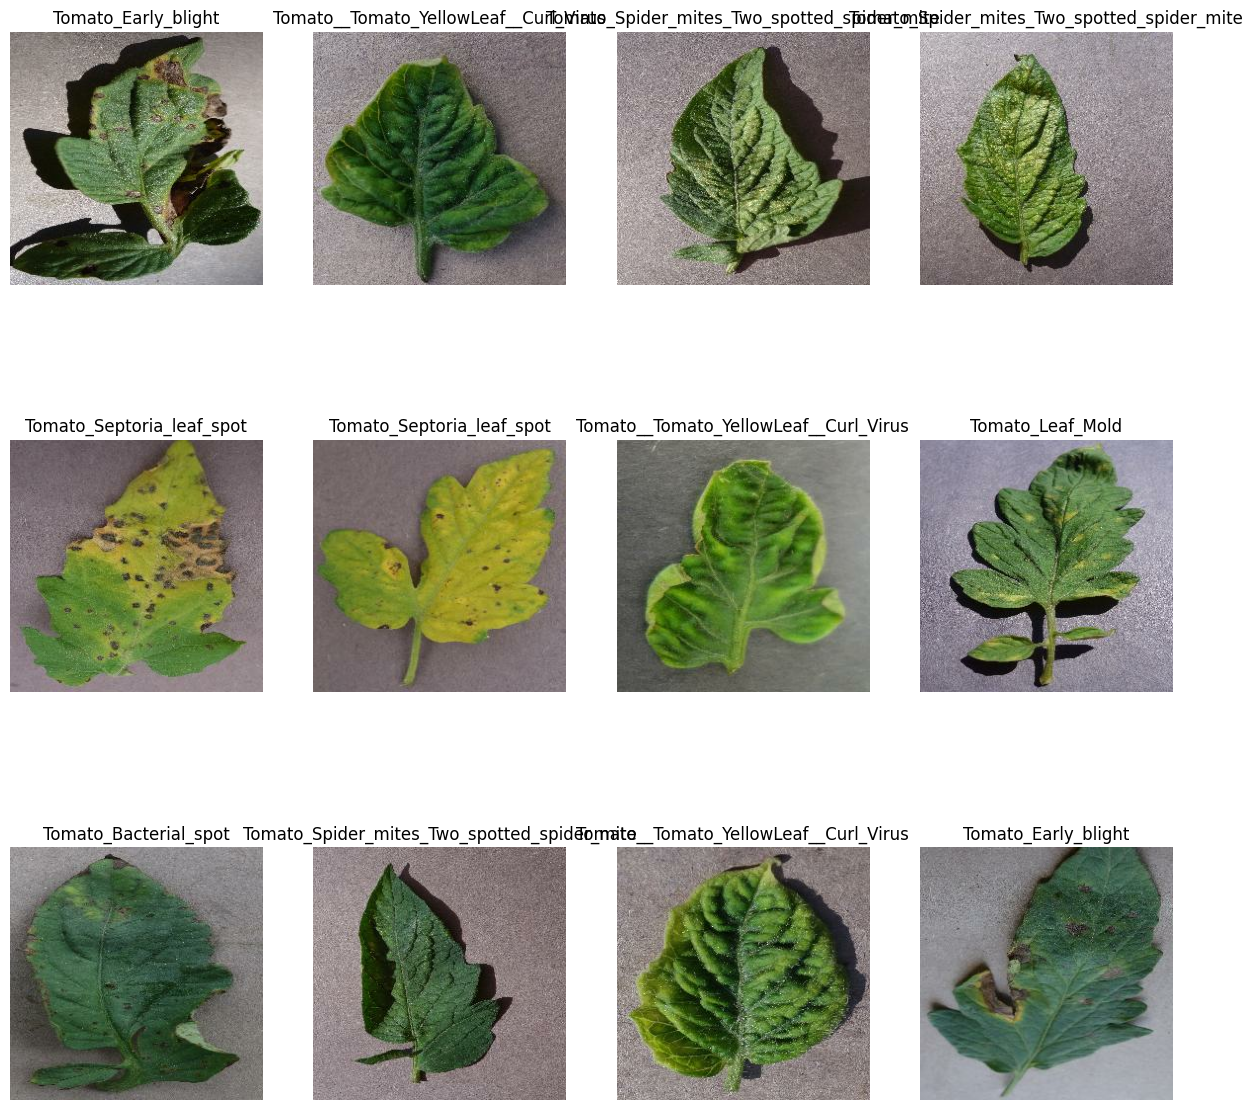

In [5]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i  in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

### Split of Dataset

80 => training

10 => validation

10 => testing 

In [6]:
train_size = 0.8
len(dataset) * train_size
len(dataset.skip(50))

13

In [7]:
train_dataset = dataset.take(50)
test_dataset = dataset.skip(50)
validation_dataset = test_dataset.take(6)

In [8]:
test_dataset = test_dataset.skip(6)

In [9]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size = 10000):
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(dataset_size * train_split)
    validation_size = int(dataset_size * val_split)

    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size).take(validation_size)
    test_dataset = dataset.skip(train_size).skip(validation_size)
    
    
    return train_dataset,validation_dataset,test_dataset

In [10]:
train_dataset,validation_dataset,test_dataset = get_dataset_partitions_tf(dataset)

In [11]:
len(train_dataset),len(validation_dataset),len(test_dataset)

(50, 6, 7)

In [12]:
# Caching the data
# caching
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [13]:
# generally the image numbers are between 255 and 1 so now we must scale it between 0 and 1 
resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1./255)
])

In [14]:
# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2)
])


In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(9, activation='softmax'),
])


model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (256, 256, 256, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (256, 254, 254, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (256, 127, 127, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (256, 125, 125, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (256, 62, 62, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (256, 60, 60, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (256, 30, 30, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (256, 28, 28, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (256, 14, 14, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (256, 12, 12, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (256, 6, 6, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (256, 4, 4, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (256, 2, 2, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (256, 256)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (256, 64)                   │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (256, 9)                    │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,137 (719.29 KB)

 Trainable params: 184,137 (719.29 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
# train_dataset = train_dataset.map(lambda x, y: (x, to_categorical(y, num_classes=n_classes)))
# validation_dataset = validation_dataset.map(lambda x, y: (x, to_categorical(y, num_classes=n_classes)))

In [24]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Program Files\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "C:\Program Files\Python312\Lib\asyncio\events.py", line 88, in _run

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\User\AppData\Local\Temp\ipykernel_18620\3560788747.py", line 1, in <module>

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 368, in fit

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 216, in function

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 129, in multi_step_on_iterator

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 59, in train_step

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\trainers\trainer.py", line 399, in _compute_loss

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\trainers\trainer.py", line 367, in compute_loss

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\trainers\compile_utils.py", line 692, in __call__

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\trainers\compile_utils.py", line 701, in call

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\losses\losses.py", line 2241, in sparse_categorical_crossentropy

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\ops\nn.py", line 1841, in sparse_categorical_crossentropy

  File "D:\AI and ML\potato_disease_classifier_application\cuda\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 714, in sparse_categorical_crossentropy

Received a label value of 9 which is outside the valid range of [0, 9).  Label values: 9 1 2 6 7 5 4 4 0 7 2 3 4 5 7 0 6 1 6 4 0 3 7 5 1 9 9 2 1 7 1 2 1 4 7 0 5 5 7 2 2 9 7 7 6 1 4 7 7 4 9 7 7 5 0 7 3 5 7 7 8 9 3 2 6 2 8 9 9 7 6 7 0 8 0 3 3 5 7 0 5 7 4 2 9 2 6 7 3 2 9 2 3 5 5 0 9 9 5 6 4 6 9 0 0 1 0 7 5 3 1 4 7 0 7 0 0 7 9 1 4 0 7 7 0 5 6 6 9 1 0 7 5 9 3 7 4 3 8 7 3 2 0 5 4 6 7 4 1 9 3 7 4 3 2 9 2 5 1 2 8 3 2 9 7 0 2 9 0 9 2 7 5 9 0 1 4 7 1 1 9 3 7 5 3 7 2 6 6 0 8 1 5 5 7 7 0 4 9 4 1 7 2 7 1 0 9 7 2 0 4 7 5 0 9 7 0 5 1 0 1 7 9 2 2 9 6 5 1 3 0 0 0 7 0 5 8 0 3 9 2 4 9 2 3 7 0 0 2 2 7 5 5 8 7 7
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_6046]